<a href="https://colab.research.google.com/github/Zhalil24/BreastMRI-CNN-Classification/blob/main/Vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!cp "/content/drive/MyDrive/data_set_zip/breast_mri_dataset.rar" /content/
!unrar x /content/breast_mri_dataset.rar /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_7848.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_7904.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8003.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8061.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8253.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8422.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8489.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8575.jpg      78%  OK 
Extracting  /content/breast_mri_dataset/train/Malignant/BREASTDX-01-0065_8605.jpg      78%  OK 
Extracti

In [11]:
# 1. AYARLAR VE CIHAZ
DATA_DIR = '/content/breast_mri_dataset'
BATCH_SIZE = 32
NUM_EPOCHS = 10
IMG_SIZE = 224 # ViT standart olarak 224x224 kullanır

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz: {device}")

Cihaz: cuda


In [12]:
# 3. ViT MODEL OLUŞTURMA VE %40 DONDURMA
def build_vit_model():
    model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

    for name, param in model.named_parameters():
        if "encoder.layers.encoder_layer_0" in name or \
           "encoder.layers.encoder_layer_1" in name or \
           "encoder.layers.encoder_layer_2" in name or \
           "encoder.layers.encoder_layer_3" in name or \
           "encoder.layers.encoder_layer_4" in name or \
           "conv_proj" in name:
            param.requires_grad = False

    model.heads.head = nn.Linear(model.heads.head.in_features, 2)
    return model.to(device)

In [13]:
# 4. EĞİTİM VE DEĞERLENDİRME FONKSİYONLARI
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
    return running_loss / len(loader.dataset), correct.double() / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
    return running_loss / len(loader.dataset), correct.double() / len(loader.dataset)

In [14]:
# 5. TRAIN-VALIDATION SPLIT VE SADE OPTIMIZER

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=test_transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = build_vit_model()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

history = {'train_acc': [], 'val_acc': []}
print(f"\n--- Tek Eğitim Başlangıcı ---")
for epoch in range(NUM_EPOCHS):
    t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    v_loss, v_acc = evaluate(model, val_loader, criterion)
    history['train_acc'].append(t_acc.item())
    history['val_acc'].append(v_acc.item())
    print(f"Epoch {epoch+1}: Train Acc: {t_acc:.4f} | Val Acc: {v_acc:.4f}")

Afold_results = [history]

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 204MB/s]



--- Tek Eğitim Başlangıcı ---
Epoch 1: Train Acc: 0.8926 | Val Acc: 0.9795
Epoch 2: Train Acc: 0.9841 | Val Acc: 0.9468
Epoch 3: Train Acc: 0.9924 | Val Acc: 0.9929
Epoch 4: Train Acc: 0.9961 | Val Acc: 0.9887
Epoch 5: Train Acc: 0.9967 | Val Acc: 0.9851
Epoch 6: Train Acc: 0.9968 | Val Acc: 0.9890
Epoch 7: Train Acc: 0.9967 | Val Acc: 0.9902
Epoch 8: Train Acc: 0.9968 | Val Acc: 0.9869
Epoch 9: Train Acc: 0.9957 | Val Acc: 0.9938
Epoch 10: Train Acc: 0.9989 | Val Acc: 0.9783


In [15]:
# 6. TEST VE GÖRSELLEŞTİRME (ResNet/EfficientNet ile aynı yapı)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        all_preds.extend(torch.max(outputs, 1)[1].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


print(f"\nTest Accuracy: {accuracy_score(all_labels, all_preds):.4f}")


Test Accuracy: 0.9786


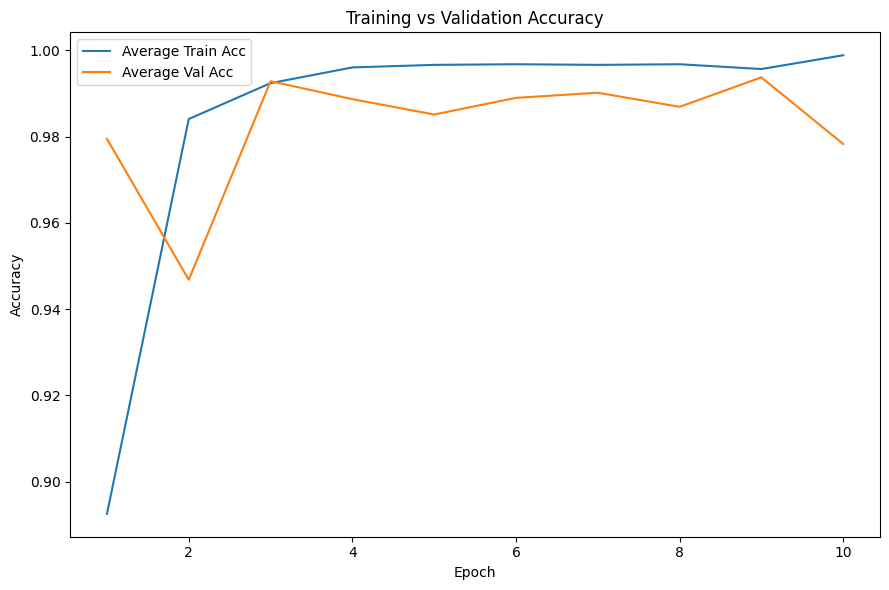

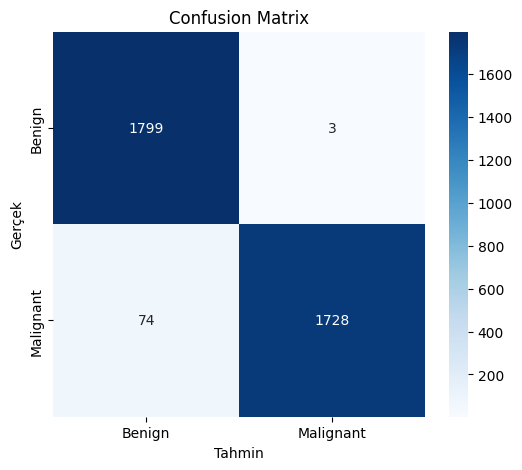

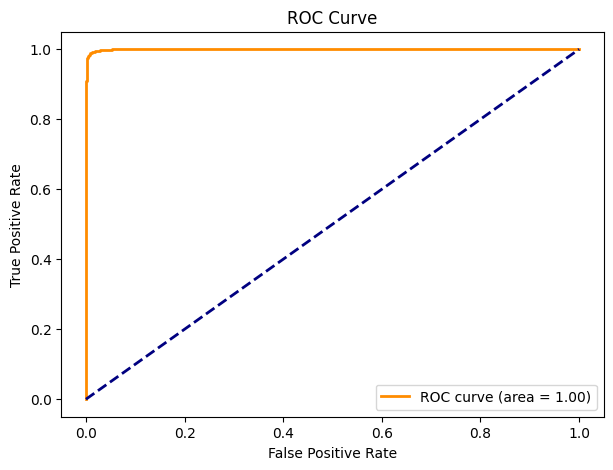

In [16]:
# 8. GÖRSELLEŞTİRME (ViT Sonuçları İçin)

# A. Accuracy Grafiği
plt.figure(figsize=(9, 6))
all_train = np.mean([f['train_acc'] for f in fold_results], axis=0)
all_val = np.mean([f['val_acc'] for f in fold_results], axis=0)
epochs = range(1, NUM_EPOCHS + 1)

plt.plot(epochs, all_train, label='Average Train Acc')
plt.plot(epochs, all_val, label='Average Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# B. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()

# C. ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(all_labels, all_probs):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()